In [1]:
%%bash
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C ../../deep_learning/data/models/
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C ../../deep_learning/data/models/
rm adv_inception_v3_2017_08_18.tar.gz

inception_v3.ckpt
adv_inception_v3.ckpt.data-00000-of-00001
adv_inception_v3.ckpt.index
adv_inception_v3.ckpt.meta


--2018-04-15 05:30:28--  http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.217.48, 2607:f8b0:400a:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.217.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100885009 (96M) [application/x-tar]
Saving to: ‘inception_v3_2016_08_28.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 2.92M 33s
    50K .......... .......... .......... .......... ..........  0% 6.99M 23s
   100K .......... .......... .......... .......... ..........  0% 10.5M 19s
   150K .......... .......... .......... .......... ..........  0% 12.4M 16s
   200K .......... .......... .......... .......... ..........  0% 22.4M 14s
   250K .......... .......... .......... .......... ..........  0% 19.3M 12s
   300K .......... .......... .......... .......... ..........  0% 33.5M 11s
   350K .......... .......... ..

In [1]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/inception_tensorflow.ipynb
import pandas as pd
import numpy as np
from sklearn import metrics

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

from skater.util.dataops import json_validator
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal 
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_visualizer import visualize

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
slim = tf.contrib.slim

file_directory = '../../../Skater/build/lib/skater/util/model_specific/imagenet_label.json'
json_data = open(file_directory).read()
json_validator(json_data)

True

In [3]:
resized_img = load_image('../../deep_learning/data/images/pandas.jpg', 299, 299)
input_resized_img = resized_img.reshape((1, 299, 299, 3))

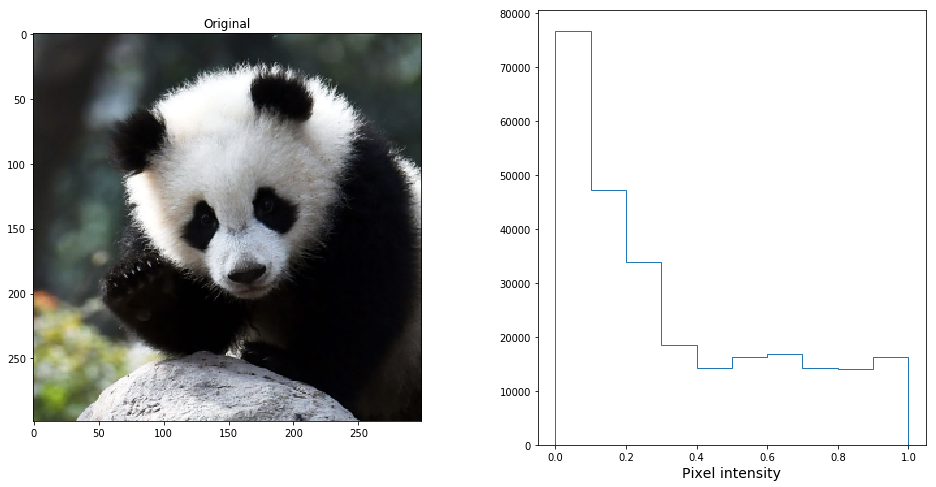

In [4]:
%matplotlib inline
show_image(input_resized_img[0])

In [5]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = '../../deep_learning/data/models/inception_v3.ckpt'

In [6]:
# Load the labels related to imagenet dataset
import json
tf.reset_default_graph()
sess = tf.Session()
labels = json.loads(json_data)

In [7]:
tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_resized_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    print('Class Labels:{}'.format([labels[str(ix)] for ix in index[0]]))
    print("Probability scores: {}".format(label_prob))

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
Class Labels:['giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca', 'soccer ball', 'space shuttle']
Probability scores: [[9.3464375e-01 1.2197685e-03 6.0174422e-04]]


In [8]:
from skater.util.logger import build_logger
from skater.util.logger import _INFO

with DeepInterpreter(session=sess) as de:
    de.logger = build_logger(_INFO, __name__)
    relevancy_scores = {
       'ig': de.explain('integ_grad', tf.reduce_max(logits, 1), X, input_X),
    }
    print ("success...")

2018-04-16 22:08:48,716 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>), ('integ_grad', <class 'skater.core.local_interpretation.dnni.relevance_scorer.IntegratedGradients'>)])
2018-04-16 22:08:48,717 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.relevance_scorer.IntegratedGradients'>
2018-04-16 22:08:48,718 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.relevance_scorer.IntegratedGradients object at 0x7f25f7766f28>


success...


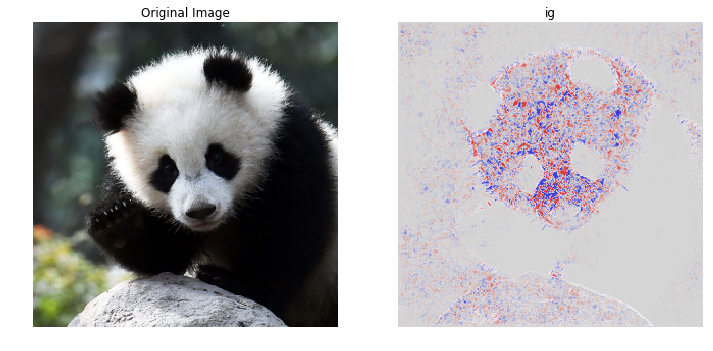

In [9]:
# Plot relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original Image')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

### Transforming the image to generate adversarial example

#### 1. Measuring sensitivity by flipping pixels

2018-04-16 22:09:37,347 - skater.util.image_ops - INFO - Number of pixels matching the condition : 18573
2018-04-16 22:09:37,348 - skater.util.image_ops - INFO - Number of pixels specified to be replaced : 3000


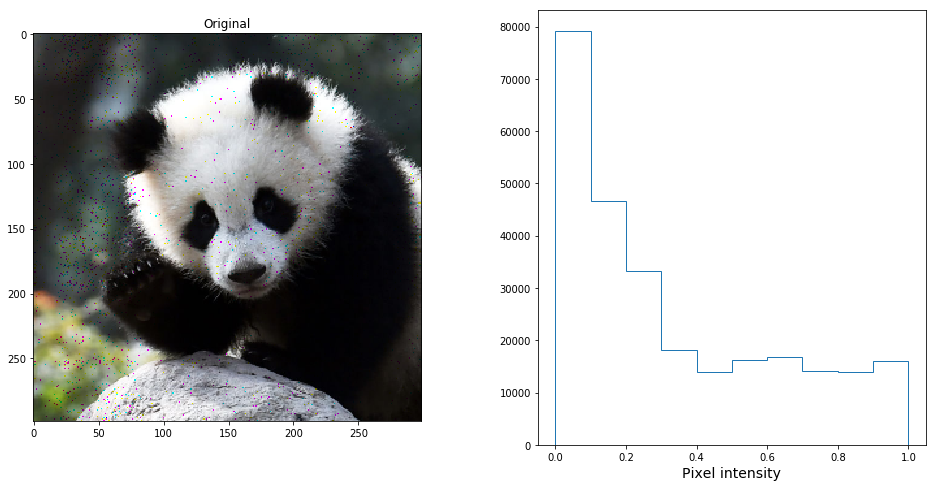

In [10]:
X = input_resized_img[0]
n_in_img = flip_pixels(X, 3000, filtered_pixel=in_between(X, 0.3, 0.4))
show_image(n_in_img)

In [11]:
input_img = normalize(n_in_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    print('Class Labels:{}'.format([labels[str(ix)] for ix in index[0]]))
    print("Probability scores: {}".format(label_prob))

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
Class Labels:['giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca', 'soccer ball', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens']
Probability scores: [[9.3559378e-01 1.1248252e-03 8.9215394e-04]]


In [12]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X),
       'ig': de.explain('integ_grad', tf.reduce_max(logits, 1), X, input_X),
    }
    print ("success...")

success...


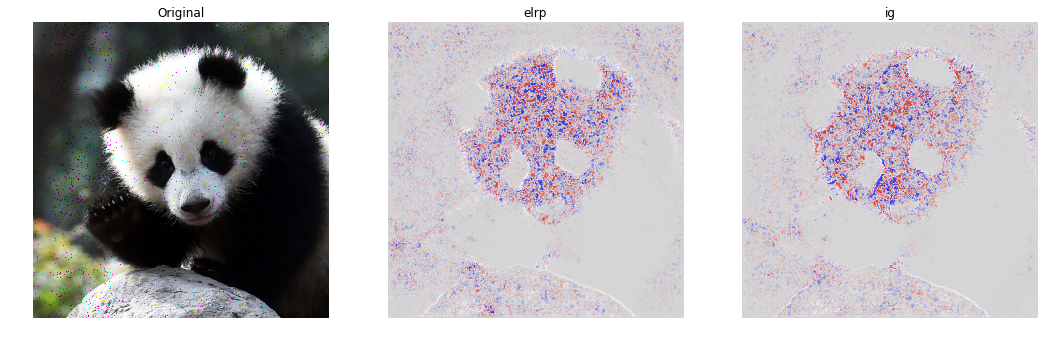

In [13]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

#### 2. By adding noise

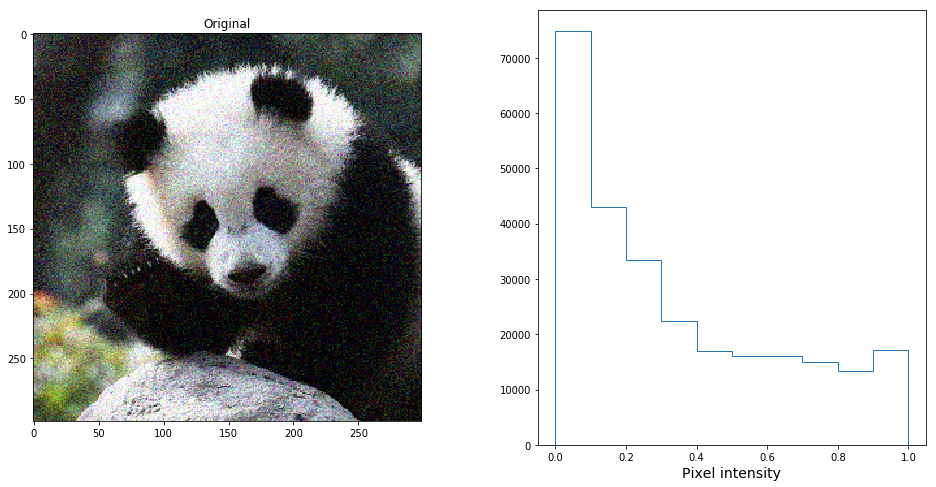

In [14]:
# a. gaussian noise
with_noise = add_noise(input_resized_img[0], noise_typ='gaussian', random_state=0)
show_image(with_noise)

#### 3. By image transformation

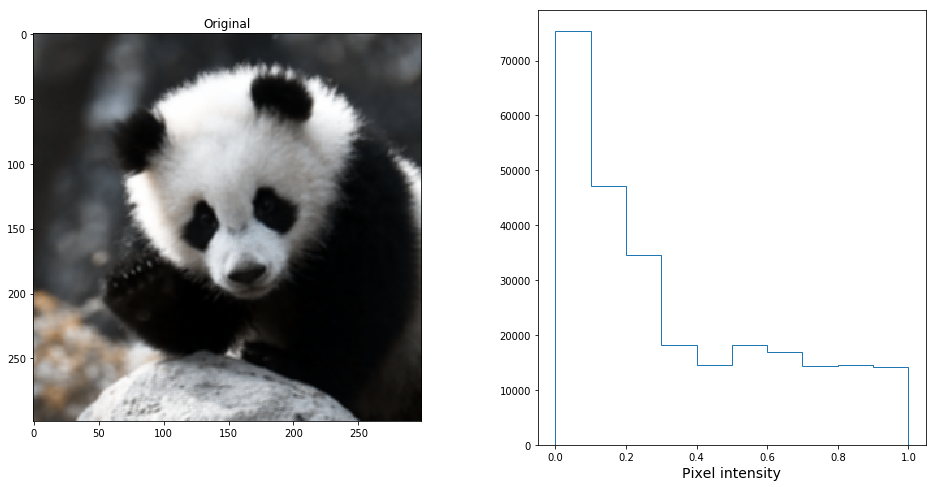

In [15]:
# 3.1. Trying blurring an image
transformed_img = image_transformation(input_resized_img[0], method_type='blur')
show_image(transformed_img)

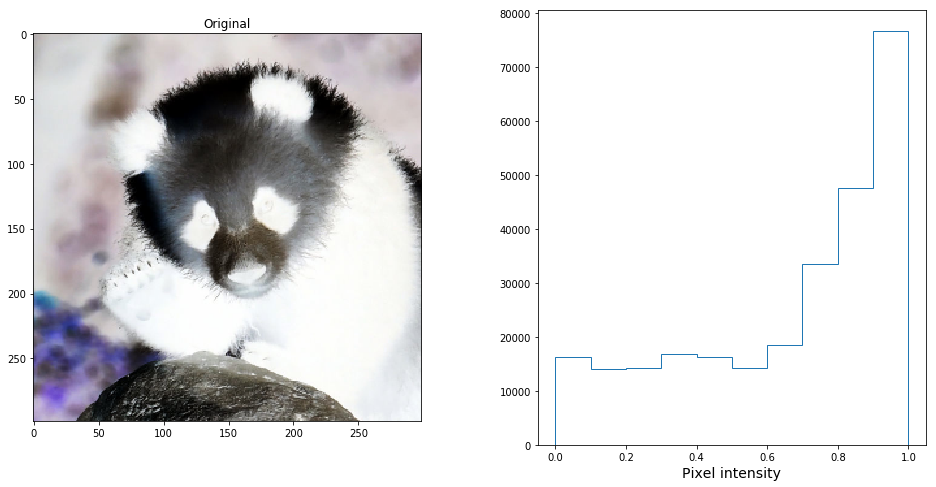

In [16]:
# 3.2 Applying color inversion
transformed_img = image_transformation(input_resized_img[0], method_type='invert')
show_image(transformed_img)

In [17]:
input_img = normalize(transformed_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    print('Class Labels:{}'.format([labels[str(ix)] for ix in index[0]]))
    print("Probability scores: {}".format(label_prob))

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
Class Labels:['indri, indris, Indri indri, Indri brevicaudatus', 'guenon, guenon monkey', 'colobus, colobus monkey']
Probability scores: [[0.26648462 0.0377436  0.0351038 ]]


In [18]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X),
    }
    print ("success...")

success...


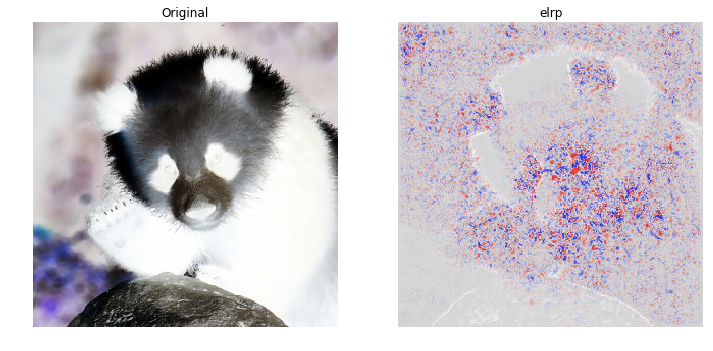

In [19]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)